In [16]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from utils import *
import plotly.graph_objects as go

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import euclidean
from voronoi_mod import *

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
short_name_map = load_json_file('data/short_name_map.json')

In [18]:
events_path = 'data/wyscout_events.parquet'
events_df = pd.read_parquet(events_path)

In [19]:
follow_files = os.listdir('data/follow_data_2')
len(follow_files)

102

In [20]:
follow_df = pd.DataFrame()
for f in follow_files:
    df = pd.read_csv(f'data/follow_data_2/{f}')
    follow_df = pd.concat([follow_df, df], ignore_index = True)

In [21]:
follow_df.shape

(6836, 40)

In [22]:
follow_df['sk_recipient_id'] = follow_df['pass_recipient_name'].map(short_name_map)
follow_df['long_name'] = follow_df.apply(lambda row: find_name(row['sk_match_id'], row['sk_recipient_id']), axis = 1)
follow_df = follow_df[~follow_df['ball_x_0'].isna()]
cols_to_num = ['ball_x_0', 'ball_y_0', 'ball_x_1', 'ball_y_1', 'ball_x_2', 'ball_y_2', 'ball_x_3', 'ball_y_3']
follow_df[cols_to_num] = follow_df[cols_to_num].apply(pd.to_numeric, errors='coerce')

In [23]:
follow_df.shape

(6818, 42)

In [24]:
#follow_df.to_csv('data/follow_df.csv', index = False)

#### Assign scores

In [25]:
for idx, row in follow_df.iterrows():
    match_id = row['sk_match_id']
    pitch_length, pitch_width = find_pitch_size(match_id)
    factor = 1 if row['receive_x'] > 0 else -1
    dist_0 = euclidean_distance(row['receive_x'], row['receive_y'], factor*pitch_length/2, 0)
    dist_1 = euclidean_distance(row['player_x_1'], row['player_y_1'], factor*pitch_length/2, 0)
    dist_2 = euclidean_distance(row['player_x_2'], row['player_y_2'], factor*pitch_length/2, 0)
    dist_3 = euclidean_distance(row['player_x_3'], row['player_y_3'], factor*pitch_length/2, 0)

    follow_df.at[idx, 'dist_0'] = dist_0
    follow_df.at[idx, 'dist_1'] = dist_1
    follow_df.at[idx, 'dist_2'] = dist_2
    follow_df.at[idx, 'dist_3'] = dist_3

In [26]:
follow_df['score_1'] = follow_df.apply(lambda row: 1 if row['dist_0'] - row['dist_1'] > 2 else 0, axis = 1)
follow_df['score_2'] = follow_df.apply(lambda row: 1 if row['dist_0'] - row['dist_2'] > 2 else 0, axis = 1)
follow_df['score_3'] = follow_df.apply(lambda row: 1 if row['dist_0'] - row['dist_3'] > 2 else 0, axis = 1)

#### Calculate SoF and player count

In [27]:
match_dict = follow_df.groupby('sk_match_id')['receive_frame'].apply(list).to_dict()

In [28]:
for match_id, frames in match_dict.items():
    extended_frames = frames + [frame + 4 for frame in frames] + [frame + 5 for frame in frames]
    match_dict[match_id] = extended_frames

In [29]:
%%time
SoF_list = []
defender_count_list = []
attacker_count_list = []
defend_score_list = []
attack_score_list = []
team_list = []
paired_player_id_list = []
paired_player_list = []
min_distance_list = []
defender_box_count_list = []
MPD_list = []
receipient_name_list = []
current_match = None

for idx, row in follow_df.iterrows():    
    match_id = row['sk_match_id']
    # import match info and pass frames when looping to new match_id
    if current_match != match_id:
        current_match = match_id
        tracking_file_path = f'data/FA/tracking/{match_id}.jsonl'
        frame_list = match_dict[match_id]
        with jsonlines.open(tracking_file_path, 'r') as file:
            frames_data = [line for line in file if line['frame'] in frame_list]
        frames_df = pd.DataFrame(frames_data)
        match_file_path = f'data/FA/match/{match_id}.json'
        match_data = load_json_file(match_file_path)  
        pitch_length, pitch_width = match_data['pitch_length'], match_data['pitch_width']
        
        home_id = match_data['home_team']['id']
        away_id = match_data['away_team']['id']
        
        home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
        away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]  

        event_match = events_df[events_df['sk_match_id'] == match_id]
        event_match_shot = event_match[(event_match['type_primary'] == 'shot') & (event_match['shot_isgoal'] == True)]
        home_score = event_match_shot[event_match_shot['sk_team_id'] == home_id]
        away_score = event_match_shot[event_match_shot['sk_team_id'] == away_id]
    
    recipient_id = row['sk_recipient_id']       
    frame = row['receive_frame'] 
    frame_df = frames_df[frames_df['frame'] == frame]
    receipient_name_data = [p for p in match_data['players'] if p['id'] == recipient_id][0]
    receipient_name = receipient_name_data['first_name'] + ' ' + receipient_name_data['last_name']
    expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
    recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()
    team_list.append(recipient_team)
    receipient_name_list.append(receipient_name)

    # Extract location data and find the paired defender
    ball_xy = row['ball_x_0'], row['ball_y_0']
    defending_df = expanded_df[~expanded_df['team'].isin([recipient_team, 'ball'])]
    defending_xy = defending_df[['x', 'y']].to_numpy()

    receive_x, receive_y = row['receive_x'], row['receive_y']
    paired_row, min_distance = find_nearest_row(defending_df, receive_x, receive_y)
    paired_player_id = paired_row['player_id']
    paired_player_data = [p for p in match_data['players'] if p['id'] == paired_player_id][0]
    paired_player = paired_player_data['first_name'] + ' ' + paired_player_data['last_name']

    paired_player_id_list.append(paired_player_id)
    paired_player_list.append(paired_player)    
    min_distance_list.append(min_distance)

    # Calculate MPD    
    MPD_frames_df = frames_df[frames_df['frame'].isin([frame + 4, frame + 5])]
    MPD_expanded_df = pd.concat(MPD_frames_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    MPD_ball_df = MPD_expanded_df[MPD_expanded_df['player_id'] == 0]
    MPD_pair_df = MPD_expanded_df[MPD_expanded_df['player_id'] == paired_player_id] 
    positions_ball = MPD_ball_df[['x', 'y']].to_numpy()
    positions_pair = MPD_pair_df[['x', 'y']].to_numpy()
    delta_t = 0.1
    velocities_ball = (positions_ball[1] - positions_ball[0]) / delta_t
    velocities_pair = (positions_pair[1] - positions_pair[0]) / delta_t      

    xy_ball = positions_ball[1]
    xy_pair = positions_pair[1]
    distance = lambda t: np.linalg.norm((xy_ball + velocities_ball * t) - (xy_pair + velocities_pair * t))
    result = minimize(distance, 0, bounds=[(0, None)])
    MPD = result.fun
    MPD_list.append(MPD)    
    
    # Get direction
    factor_x = 1 if ball_xy[0] > 0 else -1
    factor_y = 1 if ball_xy[1] > 0 else -1      

    # Extract score data
    home_score_before = home_score[home_score['frame'] < frame]
    away_score_before = away_score[away_score['frame'] < frame]
    attack_score = len(home_score_before) if recipient_team == 'home' else len(away_score_before)
    defend_score = len(away_score_before) if recipient_team == 'home' else len(home_score_before)
    attack_score_list.append(attack_score)
    defend_score_list.append(defend_score)

    # Calculate SoF
    boundary_points = np.array(
        [[ball_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-ball_xy[1])], 
         [ball_xy[0], ball_xy[1] - 40*factor_y],
         [pitch_length/2*factor_x+(pitch_length/2*factor_x-ball_xy[0]), ball_xy[1]],
         [ball_xy[0] - 40, ball_xy[1]], 
         [ball_xy[0] + 40, ball_xy[1]]])   

    points = np.vstack([ball_xy, defending_xy, boundary_points])
    points_nbs = get_neighbors(points, ball_xy)
    vertices = get_vertices(points_nbs, ball_xy)
    area_inside, area_outside, vertices_inside, vertices_outside = get_areas(vertices, ball_xy, factor_x, pitch_length)
    SoF = area_inside + np.log(area_outside+1)
    SoF_list.append(SoF)

    # Calculate count
    defender_box_df = defending_df[(defending_df['x']*factor_x > (pitch_length/2 - 16.5)) & (abs(defending_df['y']) <= 20.2)]
    defender_box_count = len(defender_box_df) - 1
    defender_deep_df = defending_df[defending_df['x']*factor_x > (ball_xy[0] *factor_x - 2)]
    defender_deep_count = len(defender_deep_df) - 1
    attacker_deep_df = expanded_df[(expanded_df['team'] == recipient_team) & (
        expanded_df['x']*factor_x > (ball_xy[0] *factor_x - 2))]
    attacker_deep_count = len(attacker_deep_df) - 1

    defender_box_count_list.append(defender_box_count)
    defender_count_list.append(defender_deep_count)
    attacker_count_list.append(attacker_deep_count)

CPU times: total: 5min 50s
Wall time: 5min 54s


In [30]:
follow_df['attack_score'] = attack_score_list
follow_df['defend_score'] = defend_score_list
follow_df['SoF'] = SoF_list
follow_df['defender_box_count'] = defender_box_count_list
follow_df['attacker_count'] = attacker_count_list
follow_df['defender_count'] = defender_count_list
follow_df['team'] = team_list
follow_df['paired_player_id'] = paired_player_id_list
follow_df['paired_player'] = paired_player_list
follow_df['min_distance'] = min_distance_list
follow_df['MPD'] = MPD_list
follow_df['receipient_name'] = receipient_name_list

In [31]:
follow_df['score_diff'] = follow_df['attack_score'] - follow_df['defend_score']

In [32]:
follow_df['success'] = ((follow_df['score_1'] == 1) | (follow_df['score_2'] == 1)).astype(int)

#### Clean data

In [33]:
follow_df['ball_dist_1'] =  follow_df.apply(lambda row: euclidean_distance(row['player_x_1'], row['player_y_1'], row['ball_x_1'], row['ball_y_1']), axis = 1)

In [34]:
follow_df = follow_df[follow_df['ball_dist_1'] < 5]

In [35]:
#follow_df['ball_dist_2'] =  follow_df.apply(lambda row: euclidean_distance(row['player_x_2'], row['player_y_2'], row['ball_x_2'], row['ball_y_2']), axis = 1)

<Axes: >

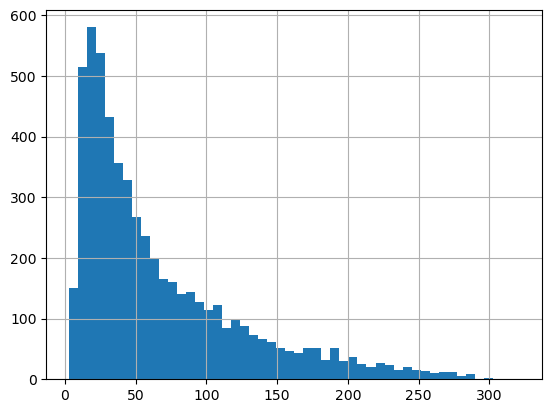

In [36]:
follow_df['SoF'].hist(bins = 50)

In [37]:
follow_df.to_csv('model_1/model_2_data.csv', index = False)

#### Calculate target variable

In [107]:
def w_exponential(t, lambd):
    return np.exp(-lambd * (t - 1))

In [108]:
lambd = 0.8
weights = [w_exponential(t + 1, lambd) for t in range(3)] 

In [109]:
weights

[1.0, 0.44932896411722156, 0.20189651799465538]

In [110]:
follow_df['combined_score'] = follow_df[['score_1', 'score_2', 'score_3']].values @ weights

In [111]:
follow_df[['score_1', 'score_2', 'score_3', 'combined_score' ]].head()

,score_1,score_2,score_3,combined_score
0,1,0,0,1.000000
1,0,0,0,0.000000
3,1,1,0,1.449329
4,1,1,0,1.449329
5,0,0,0,0.000000
